In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, RepeatVector, TimeDistributed 
from tensorflow.keras.utils import plot_model
import warnings
warnings.filterwarnings("ignore")

In [2]:
returns = pd.read_pickle("./Data/returns.pkl")
returns = returns.iloc[1:]
returns.head()

,905270,921795,904261,905261,916328,923024,936365,902355,912215,929813,...,9660J1,69568X,543755,77463M,29235J,131745,69487D,68157P,9110RA,292703
date,,,,,,,,,,,,,,,,,,,,,
1990-01-03,-0.835165,-0.475059,5.000000,-0.810537,0.361421,0.000000,-3.030303,0.000000,-0.431034,-1.315789,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-04,-0.797872,-1.272872,2.380952,-1.634321,-0.180060,3.454545,-1.562500,0.530612,0.225108,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-05,-2.546917,1.531023,-0.372093,-1.661475,-1.079730,1.054482,-3.174603,0.487211,-0.656531,-1.333333,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-08,2.017423,-0.873016,0.000000,2.534319,0.000000,0.000000,0.000000,1.010101,0.434783,3.405405,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-09,-1.123596,-2.962370,-0.404606,-1.098524,-0.364707,-1.043478,1.639344,0.000000,0.432900,-3.293257,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
# dropping columns with all NaN
drop_columns = []

for col in returns.columns:
    if returns[col].isnull().all() == True:
        drop_columns.append(col)
        
returns.drop(columns=drop_columns, inplace=True)

In [4]:
def get_investable(t, n_rows):
    "Find stocks in investable universe at time t\
    (stocks in the S&P500 that have prices recorded for the last n_rows days)"
    
    df_investable = returns.copy(deep = True).sort_index(ascending = False)
    
    t_index = df_investable.index.get_loc(t)
    
    #take n_rows worth of data upto time specified
    df_investable = df_investable.iloc[t_index + 1:t_index + n_rows + 1]
    
    #find all stocks that exist in the S&P at this time period
    investable_universe = []
    for col in df_investable.columns:
        if ~df_investable[col].iloc[:n_rows].isna().any():
            investable_universe.append(col)
        
    df_investable = df_investable[investable_universe]
    
    return df_investable

In [5]:
# all stocks starting May 22 to 504 days before with stock returns listed
t = pd.to_datetime("2020-02-25")
get_investable(t, 80)

,916328,936365,905271,905113,905802,905425,906156,916305,992816,921093,...,311917,69568X,543755,77463M,29235J,131745,69487D,68157P,9110RA,292703
date,,,,,,,,,,,,,,,,,,,,,
2020-02-24,-3.224700,-7.807808,-3.702396,-1.195098,-6.519714,-1.641923,-4.974055,-5.967078,-4.750040,-2.460137,...,-2.020070,-7.459489,-2.467504,-6.481638,-6.091830,-4.945782,-4.950192,-2.934848,-7.530828,-3.530293
2020-02-21,-1.141759,-6.966998,-0.168363,-0.682511,-0.463535,-0.654425,-1.230048,-2.409639,-2.263503,-0.746100,...,-1.364204,0.176838,-1.604162,0.595846,-4.036727,-0.943149,-3.189911,-0.666838,-1.943285,-1.020350
2020-02-20,-1.007162,-2.767402,-0.164178,-1.085978,1.809029,-1.082126,-0.255605,0.789314,-1.025895,0.591312,...,-0.471153,-1.963115,0.348053,2.656414,-1.813720,2.884097,-0.111152,0.610700,0.028798,-1.631715
2020-02-19,0.540054,3.533134,0.031282,2.682395,3.974485,-0.795553,0.980826,0.816160,1.448276,-1.079865,...,-1.072034,6.875586,0.767207,42.444610,1.149301,0.487541,0.806753,4.644464,0.915432,1.375625
2020-02-18,-0.869953,2.856626,-0.105465,-0.539684,1.325820,0.549345,-0.198719,1.093234,-1.831051,-0.714764,...,1.049026,7.295914,0.573192,-2.238988,-3.065014,0.135612,-2.341698,-1.907116,-0.159582,-0.317316
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-11-04,-0.532301,4.012611,0.402697,0.841108,0.478886,-0.812313,0.402887,2.176339,0.656712,1.484798,...,-1.623956,1.327758,0.808427,-4.646840,3.548014,1.655398,-0.101695,1.448802,1.693443,-0.647981
2019-11-01,-1.136228,2.829355,0.140673,3.894889,4.806084,-0.879330,1.585948,1.510574,2.838077,0.927688,...,-0.091610,-0.511083,2.459839,-3.088008,3.775347,0.609899,3.800141,-4.949265,2.881394,2.108017
2019-10-31,-0.476134,2.414730,-1.601070,-0.217991,1.528721,0.308183,-0.669095,0.665273,2.260955,3.725635,...,0.210180,-0.028729,1.374046,3.571429,-1.160338,-2.448513,-0.984235,4.219273,0.947012,-1.946288


In [6]:
# Converts investable dataframe into 3D tensor for input into RNN fitting
# Eg. if investable_df has shape (52, 635), it is converted to a numpy array of shape (52, 1, 635)

def formatX(investable_df):
    train_values = []
    # Iterates through each day in investable df and appends feature values to train_values
    for i in range(len(investable_df.index)):
        train_values.append(investable_df.iloc[i].values)
    train_values = np.array(train_values) # converts to numpy array
    train_values = np.reshape(train_values, (train_values.shape[0], 1, train_values.shape[1])) # reshapes to 3-dimensional
    return train_values

In [7]:
formatX(get_investable(t, 80))

array([[[-3.22469983, -7.80780781, -3.70239636, ..., -2.93484809,
         -7.53082795, -3.53029256]],

       [[-1.14175899, -6.96699843, -0.16836335, ..., -0.66683765,
         -1.94328487, -1.02035   ]],

       [[-1.00716204, -2.76740238, -0.16417794, ...,  0.61070015,
          0.0287977 , -1.6317147 ]],

       ...,

       [[-0.47613379,  2.41472985, -1.60107046, ...,  4.21927269,
          0.9470124 , -1.94628847]],

       [[ 0.67106052,  0.30275507, -0.50041319, ...,  1.33406233,
         -1.1589035 ,  0.10572421]],

       [[ 0.95572224, -1.95903829,  2.99791943, ..., -1.93029491,
         -0.46583851,  0.94526605]]])

In [8]:
# Formats output for a stock as a np array
# Takes in a stock, a date, and a number of rows to look back on and formats the output values as a numpy array
# Eg. formatY(stockX, Feb.25, 80) outputs the returns for stockX starting from 80 days before Feb.25 up to Feb.25

def formatY(stock, t, n_rows):
    t_index = returns.index.get_loc(t)
    return returns[stock].iloc[t_index - n_rows:t_index + 1].shift(-1).iloc[:-1].values[::-1]

In [9]:
formatY("916328", t, 80)

array([-4.1356493 , -3.22469983, -1.14175899, -1.00716204,  0.54005401,
       -0.86995316,  1.10509698, -0.12388783, -0.42615229,  0.98527746,
        0.48935928, -1.78830893, -0.10049129,  1.50742378,  1.34390076,
       -0.09180629, -2.26558995,  0.02243662, -0.44672772, -0.0558098 ,
       -0.8960177 , -0.36371652, -1.23013281,  2.37378803,  0.82022472,
        0.81558677,  1.02998398,  1.91275951,  0.72838346, -0.28116214,
       -1.24942156,  0.2667904 ,  0.40764034, -0.55594163,  0.52392595,
       -1.21909143,  0.10361501,  0.06912442, -0.68649886,  0.13748854,
        0.        , -0.08013738,  0.79621509, -0.78992559,  0.48314736,
       -0.14932231,  0.76388889,  0.05790388,  0.44201466,  1.24838064,
        0.41390728,  0.8227018 , -1.88348152,  0.28155795,  0.07043907,
        0.97202466, -0.17749379, -1.10005851,  0.03512058,  0.        ,
        1.10072198,  0.89562933,  0.07170172, -0.25032781, -0.47455214,
        0.03560408, -1.69175125,  1.89015692, -0.11873664, -0.14

In [29]:
# Similar to get_model in simpleRNN-2

def LSTM_autoencoder(stock, investable_df):
    # Converts features and output values to a 3D tensor and numpy array respectively
    convertedX = formatX(investable_df)
    t_index = returns.index.get_loc(investable_df.index[0])
    t = returns.index[t_index + 1]
    convertedY = formatY(stock, t, len(investable_df.index))
    
    # Build LSTM model with autoencoder
    model = Sequential()
    model.add(LSTM(100,activation='relu', input_shape =(convertedX.shape[1], convertedX.shape[2])))
    model.add(RepeatVector(convertedX.shape[1]))
    model.add(LSTM(100,activation='relu', return_sequences=True))
    model.add(TimeDistributed(Dense(1)))
    model.compile(optimizer="adam", loss='mse')#rnn: optimizer='rmsprop'
    
    # Fit model on formatted data
    history = model.fit(convertedX, convertedY, validation_split=0.2, epochs=50, batch_size=16, verbose=0)
    history
    #plot_model(model, show_shapes=True, to_file='reconstruct_lstm_autoencoder.png')
    # demonstrate recreation
    #yhat = model.predict(convertedX, verbose=0)
    #print(yhat[0,:,0])
    
    return model, history

In [27]:
t = pd.to_datetime("2021-05-28")
test_size = 40
look_back = 240
investable = get_investable(t, look_back + test_size)

tts = investable.index[test_size]
investable.loc[tts:]

,916328,936365,905271,905113,905802,905425,906156,916305,992816,921093,...,311917,69568X,543755,77463M,29235J,131745,69487D,68157P,9110RA,292703
date,,,,,,,,,,,,,,,,,,,,,
2021-03-31,0.075157,3.289474,-0.449382,1.164987,-0.394144,-0.035407,-1.428671,-2.386988,1.876564,-1.554404,...,0.838245,5.083194,2.301420,7.675963,3.099885,1.944769,1.805127,3.052714,0.367267,0.649430
2021-03-30,-2.028962,-1.477833,-0.478889,0.761421,-0.795978,-1.293103,0.786683,1.631602,-1.227449,1.418812,...,-0.323134,3.980124,1.009564,5.951878,0.602014,4.714388,1.869785,4.819590,5.688986,1.770631
2021-03-29,0.131072,-0.348792,-1.131537,-1.469209,-0.981748,1.000118,-0.946219,-0.512601,0.148503,-1.415990,...,0.473849,-1.199269,0.776439,-6.529888,-2.971764,-7.853256,-2.442211,-4.081793,-5.815149,-1.767116
2021-03-26,2.536749,1.561270,3.588560,2.041467,4.887600,0.318697,1.019117,0.688172,0.514139,1.810830,...,1.971693,-3.385422,3.333794,2.417834,5.847727,-1.995402,4.019654,4.986214,0.678629,2.159957
2021-03-25,0.872733,-0.339958,-0.266177,3.294893,-0.188188,-0.317684,2.788614,3.356301,0.416354,1.716738,...,-1.426080,1.605645,1.917383,0.337883,0.178283,4.507015,2.151858,1.397905,4.873341,2.078129
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-04-24,0.127741,0.500894,2.608037,-1.727273,1.895848,0.252951,0.861024,3.045013,2.886958,0.699496,...,4.452055,2.766324,-0.850805,-4.432624,2.631434,3.829161,7.209355,0.598123,14.377407,1.107420
2020-04-23,-1.612903,-0.035765,-1.478269,1.569714,5.815135,-2.329412,-0.096923,1.796945,-0.387541,0.960452,...,7.341666,-3.617011,2.268490,3.242678,-1.899556,2.259036,-1.100382,0.299959,3.797468,-1.217911
2020-04-22,1.520468,5.668934,3.399392,2.266289,8.276052,3.067782,1.251227,0.044944,2.880352,1.142857,...,3.063434,6.609758,1.578283,7.687975,4.318862,-2.137067,9.869233,2.687201,-1.702685,1.525248


In [18]:
# Test run on LSTM with autoencoder
model = LSTM_autoencoder("916328", investable.loc[tts:])

Epoch 1/50
15/15 [==============================] - 2s 7ms/step - loss: 2.7451
Epoch 2/50
15/15 [==============================] - 0s 7ms/step - loss: 2.3812
Epoch 3/50
15/15 [==============================] - 0s 8ms/step - loss: 1.5782
Epoch 4/50
15/15 [==============================] - 0s 9ms/step - loss: 0.9822
Epoch 5/50
15/15 [==============================] - 0s 7ms/step - loss: 0.4879
Epoch 6/50
15/15 [==============================] - 0s 9ms/step - loss: 0.4365
Epoch 7/50
15/15 [==============================] - 0s 7ms/step - loss: 0.3541
Epoch 8/50
15/15 [==============================] - 0s 6ms/step - loss: 0.3048
Epoch 9/50
15/15 [==============================] - 0s 6ms/step - loss: 0.2839
Epoch 10/50
15/15 [==============================] - 0s 7ms/step - loss: 0.1561
Epoch 11/50
15/15 [==============================] - 0s 7ms/step - loss: 0.1666
Epoch 12/50
15/15 [==============================] - 0s 18ms/step - loss: 0.0874
Epoch 13/50
15/15 [=============================

In [23]:
# Predicts stock price at a given date
import datetime

# Number of days to look back at when training model
look_back = 80

def pred_date(stock, date):
    investable = get_investable(date, look_back + 1)
    
    # Checking for invalid inputs
    if stock not in investable.columns:
        print(stock + " is not in the investable universe")
        return
    if investable.shape[0] == 0:
        print("Investable universe is empty")
        return
    
    ''' investable.iloc[0:1] is the first row of the investable df 
    (i.e. the row we're using to predict the stock's return at time date) '''
    convertedX = formatX(investable.iloc[0:1])
    
    ''' We train the model on the day before date (the parameter) so that the date we're predicting
    for is not included in the training set'''
    model = LSTM_autoencoder(stock, investable.iloc[1:])
    
    return model.predict(convertedX)[0, 0]

In [24]:
pred_date("916328", t)

Epoch 1/50
5/5 [==============================] - 4s 19ms/step - loss: 1.5260
Epoch 2/50
5/5 [==============================] - 0s 11ms/step - loss: 1.0723
Epoch 3/50
5/5 [==============================] - 0s 11ms/step - loss: 0.5973
Epoch 4/50
5/5 [==============================] - 0s 13ms/step - loss: 0.3730
Epoch 5/50
5/5 [==============================] - 0s 10ms/step - loss: 0.1811
Epoch 6/50
5/5 [==============================] - 0s 13ms/step - loss: 0.1077
Epoch 7/50
5/5 [==============================] - 0s 12ms/step - loss: 0.0885
Epoch 8/50
5/5 [==============================] - 0s 16ms/step - loss: 0.0681
Epoch 9/50
5/5 [==============================] - 0s 17ms/step - loss: 0.0370
Epoch 10/50
5/5 [==============================] - 0s 7ms/step - loss: 0.0237
Epoch 11/50
5/5 [==============================] - 0s 16ms/step - loss: 0.0219
Epoch 12/50
5/5 [==============================] - 0s 8ms/step - loss: 0.0085
Epoch 13/50
5/5 [==============================] - 0s 17ms/step

array([0.04322256], dtype=float32)

In [ ]:
df = pd.DataFrame()
predictions = []
actuals = []
dates = []
for date in investable.index[:test_size]:
    convertedX = formatX(investable.loc[[date]])
    prediction = model.predict(convertedX)[0, 0]
    actual = investable.loc[date, "916328"].item()
    predictions.append(prediction)
    actuals = np.append(actuals, actual)
    dates.append(date)
df["predictions"] = np.array(predictions)
df["actuals"] = actuals
df["date"] = dates
df.set_index("date", inplace=True)
df

dict_keys(['loss', 'val_loss'])


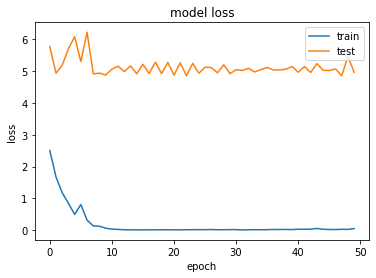

In [32]:
# get data to plot
history = LSTM_autoencoder("916328", investable.loc[tts:])[1]
print(history.history.keys())

# plot the loss history
# original
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()